In [185]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import scipy.ndimage
import dearpygui.dearpygui as dpg
import dearpygui.demo as demo
from rembg import remove
from PIL import Image
import scipy.ndimage

In [135]:
filename = 'his_grey.png' # входящее изображение
# bgrem_img = 'his_bgrem.png' # изображение с удаленным фоном
all_seg = 'his_all_seg.png' # полная маска сегментации ----- cnn для сегментации текста
output_seg = 'his_out.png' # вычитание из полной маски маски текста (работает фигово)
limpid_img = 'his_mask.png'
mask = 'mask.png'
source = 'page6.png'
hsv_mask = 'hsv_mask.png'

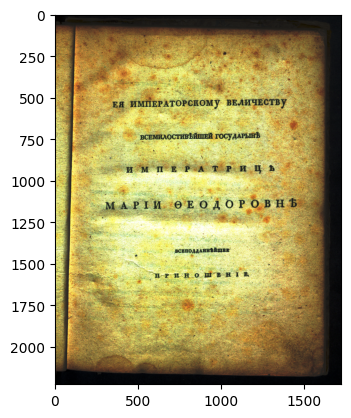

In [3]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, c = img.shape

plt.imshow(img)

In [4]:
def threshholding(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 80, 255, cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap = "gray")
    return thresh

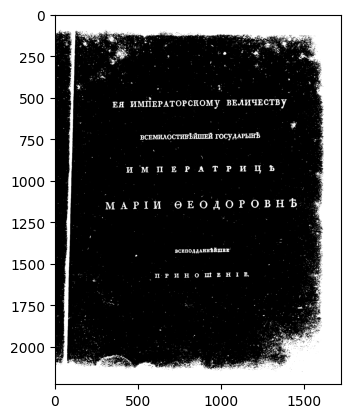

In [5]:
thresh_img = threshholding(img)

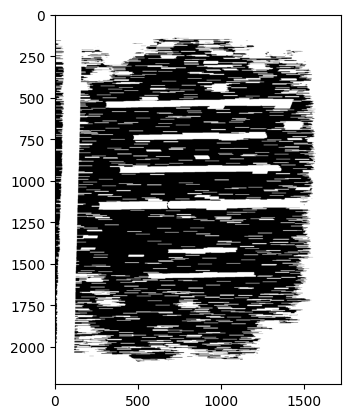

In [6]:
kernel = np.ones((3,85), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)

plt.imshow(dilated, cmap = "gray")

In [8]:
dilated = dilated.astype(np.uint8)
# print(dilated)
(contours, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1])

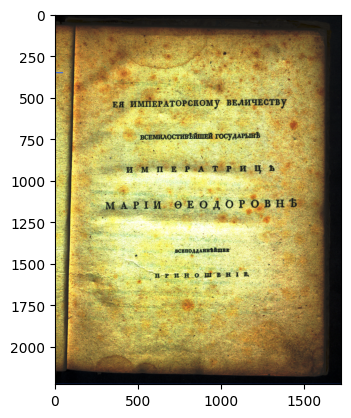

In [9]:
img2 = img.copy()

for ctr in sorted_contours_lines:
    
    x, y, w, h = cv2.boundingRect(ctr)
    cv2.rectangle(img2, (x,y), (x+w, y+h), (40, 100, 250), 2)
    
plt.imshow(img2)

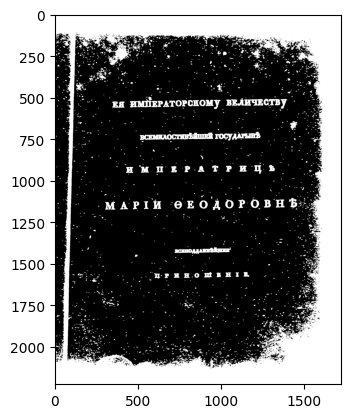

In [112]:
kernel = np.ones((3, 5), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated, cmap = "gray") #полная маска с текстом

In [11]:
# cv2.imwrite(all_seg, dilated)

True

In [141]:
bw_mask = cv2.imread(mask)

In [92]:
bw_mask = cv2.cvtColor(bw_mask, cv2.COLOR_BGR2GRAY)

In [93]:
bw_mask.shape

(2225, 1725)

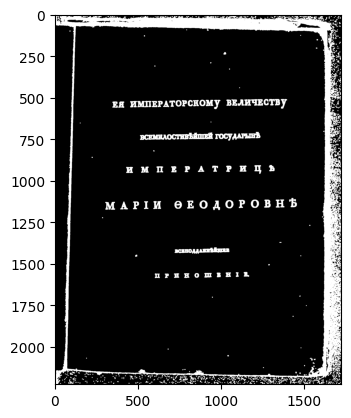

In [113]:
# (размер ядра маски текста больше, чем размер ядра общей маски)
kernel2 = np.ones((5, 5), np.uint8) 
#расширение белой области изображения маски текста
dilated_mask = cv2.dilate(bw_mask, kernel2, iterations = 1)
plt.imshow(dilated_mask, cmap = "gray")

In [114]:
new_mask = dilated - dilated_mask

In [105]:
print(new_mask)

[[255 255   0 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]


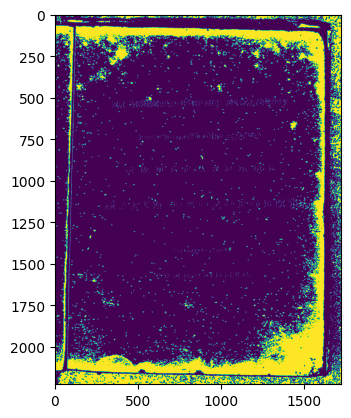

In [115]:
plt.imshow(new_mask)

In [120]:
img_source = cv2.imread(source)

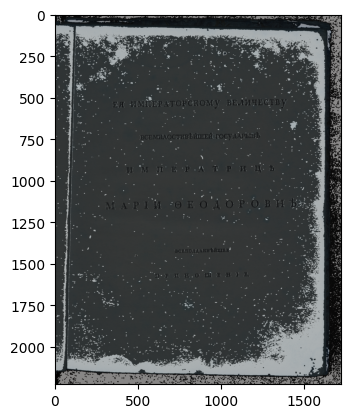

In [122]:
# наложение маски на исходник
res_musk = cv2.cvtColor(new_mask,cv2.COLOR_GRAY2RGB)
overlay = cv2.addWeighted(img_source, 0.3, res_musk, 0.5, 0)
cv2.imwrite("final_mask.png", overlay)
plt.imshow(overlay)
# дефекты виньетирования по краям

In [147]:
hsv_musk = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2RGB)

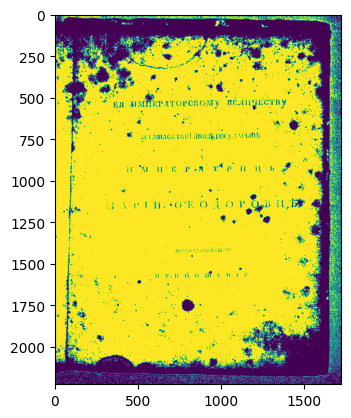

In [149]:
hsv_gray_rbg = cv2.cvtColor(hsv_mask, cv2.COLOR_RGB2GRAY)
plt.imshow(hsv_gray_rbg)

In [152]:
hsv_without_text = hsv_gray_rbg + dilated_mask
# складываем hsv маску текста и hsv маску сегмента, чтобы получить повреждения без текста

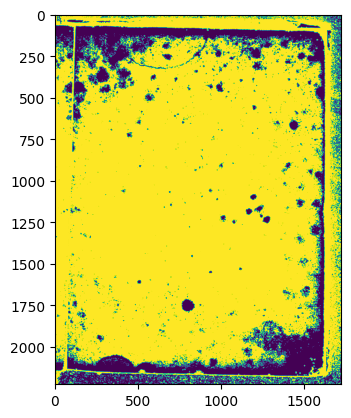

In [157]:
plt.imshow(hsv_without_text)

In [158]:
print(hsv_without_text.shape)

(2225, 1725)


In [159]:
print(img_source.shape)

(2225, 1725, 3)


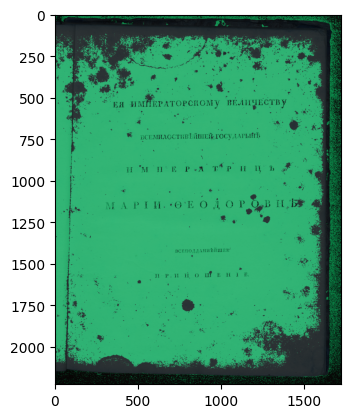

In [140]:
# фильтрация повреждений с вручную наложенной HSV маской без вычитания текста
best_mask = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2RGB)
overlay2 = cv2.addWeighted(img_source, 0.3, best_mask, 0.5, 0)
cv2.imwrite("best_mask.png", overlay2)
plt.imshow(overlay2)

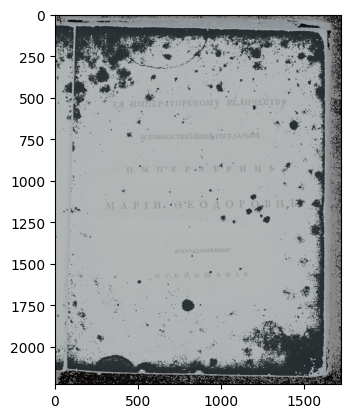

In [166]:
# фильтрация повреждений с вручную наложенной HSV маской с вычитанием текста и настройкой прозрачности
best_mask2 = cv2.cvtColor(hsv_without_text, cv2.COLOR_GRAY2RGB)
overlay3 = cv2.addWeighted(img_source, 0.3, best_mask2, 0.5, 0) # второй параметр - альфа - настройка прозрачности маски
# cv2.imwrite("best_mask3.png", overlay3)
plt.imshow(overlay3)

In [218]:
# Функция подсчета повреждений
def counter():
    count_black = np.sum(hsv_without_text == 0) #сумма черных пикселей
    count_white = np.sum(hsv_without_text == 255) #сумма белых пикселей
    # вывод значений
    print('Количество белых пикселей : ', count_white)
    print('Количество черных пикселей: ', count_black)
    # общее количество пикселей
    total_pixels = count_black + count_white
    # делим количество черных пикселей маски на общее
    damage_ratio = count_black / total_pixels
    # получаем процент повреждений
    damage_intensity = damage_ratio * 100
    # вывод значения
    print('Интенсивность повреждений:', f'{damage_intensity} %')

In [219]:
# вызов функции
counter()

Количество белых пикселей :  3030741
Количество черных пикселей:  631158
Интенсивность повреждений: 17.2358112553077 %


ДРУГИЕ ЭКСПЕРИМЕНТЫ

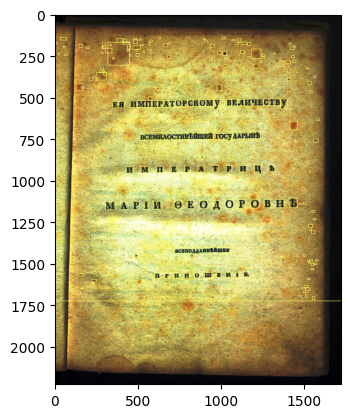

In [12]:
img3 = img.copy()
words_list = []
for line in sorted_contours_lines:
    
    x, y, w, h = cv2.boundingRect(line)
    roi_line = dilated[y:y+w, x:x+w]
    # рисуем контуры каждого слова
    (cnt, hierarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_words = sorted(cnt, key = lambda cntr: cv2.boundingRect(cntr)[0])
    
    for word in sorted_contours_words:
        # если прощадь контура меньше значения, пропустить
        if cv2.contourArea(word) < 50:
            continue
        x2, y2, w2, h2 = cv2.boundingRect(word) # рисуем bbox вокруг каждого сегмента
        words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2]) #добавляем координаты bbox в список
        cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (255,255, 100), 2) #рисуем желтые рамочки вокруг сегментов

plt.imshow(img3)

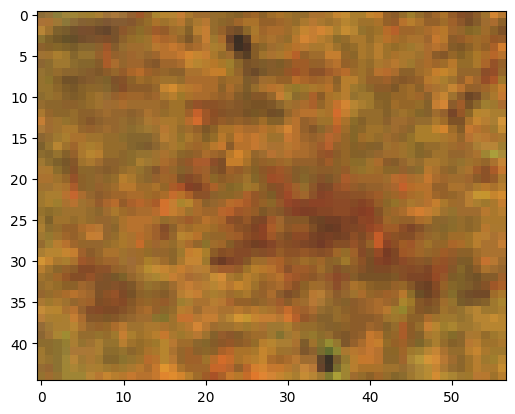

In [32]:
ninth_word = words_list[22]
roi_9 = img[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]] # сегмент изображения с текстом bbox из word_list
plt.imshow(roi_9)

In [ ]:
# запись в файл сегментов bbox с данными
# with open ('rembg_test.txt', 'w') as f:
#     for word in words_list:
#         coord_eight = f'{word[0]}, {word[1]}, {word[2]}, {word[1]}, {word[2]}, {word[3]}, {word[0]}, {word[3]}'
#         print(coord_eight)
#         # output_str = str(word).replace("[", "").replace("]", "")
#         f.write(f"{coord_eight}\n")

In [ ]:
# https://github.com/kanishk307/crack-detection-beproject/blob/master/Extraction%20Algorithm%20Function/extraction-algorithm-function.py

In [205]:
def main_algorithm(gray_image):
    def orientated_non_max_suppression(mag, ang):
        ang_quant = np.round(ang / (np.pi/4)) % 4
        winE = np.array([[0, 0, 0],[1, 1, 1], [0, 0, 0]])
        winSE = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
        winS = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]])
        winSW = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]])

        magE = non_max_suppression(mag, winE)
        magSE = non_max_suppression(mag, winSE)
        magS = non_max_suppression(mag, winS)
        magSW = non_max_suppression(mag, winSW)

        mag[ang_quant == 0] = magE[ang_quant == 0]
        mag[ang_quant == 1] = magSE[ang_quant == 1]
        mag[ang_quant == 2] = magS[ang_quant == 2]
        mag[ang_quant == 3] = magSW[ang_quant == 3]
        return mag

    def non_max_suppression(data, win):
        # data_max = scipy.ndimage.filters.maximum_filter(data, footprint=win, mode='constant')
        data_max = scipy.ndimage.maximum_filter(data, footprint=win, mode='constant')
        data_max[data != data_max] = 0
        return data_max

    # start calulcation
    # count_white = 0

    # with_nmsup = True #apply non-maximal suppression
    # fudgefactor = 1 #with this threshold you can play a little bit
    # sigma = 21 #for Gaussian Kernel
    # kernel = 2*math.ceil(2*sigma)+1 #Kernel size

    gray_image = gray_image/255.0
    # blur = cv2.GaussianBlur(gray_image, (85, 85), 21)
    blur = cv2.GaussianBlur(gray_image, (17, 17), 21)
    gray_image = cv2.subtract(gray_image, blur)

    # compute sobel response
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=31)
    sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=31)
    mag = np.hypot(sobelx, sobely)
    ang = np.arctan2(sobely, sobelx)

    # threshold
    threshold = 4 * 1 * np.mean(mag)
    mag[mag < threshold] = 0

    #either get edges directly
    # mag = cv2.normalize(mag, 0, 255, cv2.NORM_MINMAX)
    # kernel = np.ones((5,5),np.uint8)
    # result = cv2.morphologyEx(mag, cv2.MORPH_CLOSE, kernel)
        # cv2.imshow('im', result)
        # cv2.imshow('Input',input_img)
        # cv2.waitKey()
    mag = orientated_non_max_suppression(mag, ang)
    # create mask
    mag[mag > 0] = 255
    mag = mag.astype(np.uint8)
    kernel = np.ones((5,5),np.uint8)
    result = cv2.morphologyEx(mag, cv2.MORPH_CLOSE, kernel)
    return result
        

    #or apply a non-maximal suppression
    # else:
    #     # non-maximal suppression
    #     mag = orientated_non_max_suppression(mag, ang)
    #     # create mask
    #     mag[mag > 0] = 255
    #     mag = mag.astype(np.uint8)
    #     kernel = np.ones((5,5),np.uint8)
    #     result = cv2.morphologyEx(mag, cv2.MORPH_CLOSE, kernel)
        
        
    #    #TRYING FLOODFILL
    #    th, im_th = cv2.threshold(gray_image, 220, 255, cv2.THRESH_BINARY_INV);
    #    h, w = im_th.shape[:2]
    #    mask = np.zeros((h+2, w+2), np.uint8)
    #    
    #    cv2.floodFill(result, mask, (0,0), 255);
    #    im_floodfill_inv = cv2.bitwise_not(result)
    #    new = cv2.bitwise_and(result,im_floodfill_inv)
    ##    new = im_th+im_floodfill_inv
    ##    im_out = cv2.add(im_th,im_floodfill_inv)
    ##    im_out = im_th | im_floodfill_inv
    #    
    ##    cv2.imshow("Thresholded Image", im_th);
    #    cv2.imshow("Floodfilled Image", result);
    #    cv2.imshow("Inverted Floodfilled Image", im_floodfill_inv);
    #    cv2.imshow("Foreground", new);
    #    # FLOODFILL END
        
        
        #result = cv2.erode(result, result, kernel)
    # cv2.imshow('im', result)
        # count_black = np.sum(result==0)
        # count_white = np.sum(result == 255)
        # print('Number of white pixels : ', count_white)
        # print('Number of black pixels : ', count_black)
        # total_pixels = count_black + count_white
        # crack_ratio = count_white / total_pixels
        # crack_intensity = crack_ratio * 100
        # print('Crack Intensity is :', crack_intensity)
    # cv2.imshow('Input',input_img)
    # cv2.waitKey()

    


# input_img = cv2.imread('6.jpg')
#gray_image = cv2.imread(r'6.jpg', 0)

#result = main_function(gray_image)

#cv2.imshow('op',result)
#cv2.waitKey()

In [193]:
gray_image = cv2.imread(source, 0)

result = main_algorithm(gray_image)

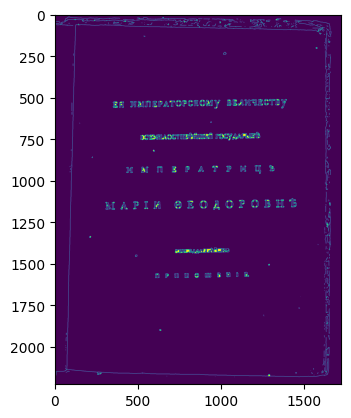

In [194]:
plt.imshow(result)
# с малоконстрастными пятнами на бумаге работа алгоритма спорна

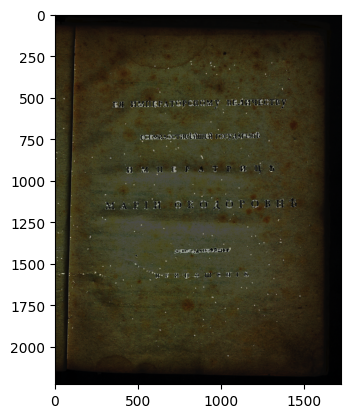

In [29]:
plt.imshow(result)

In [206]:
insects_image = "ad000087.png"

gray_image2 = cv2.imread(insects_image, 0)
result3 = main_algorithm(gray_image2)

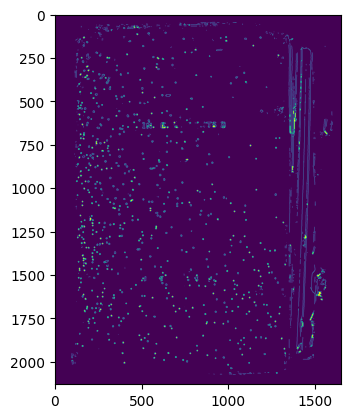

In [207]:
plt.imshow(result3)

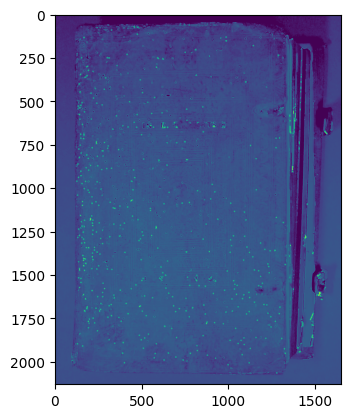

In [208]:
# Отображение алгоритма детекции контрастных объектов (трещин и насекомых)
dst2 = cv2.addWeighted(gray_image2, 0.3, result3, 0.5, 0)
plt.imshow(dst2)

In [209]:
# cv2.imwrite('crack_algh.png', dst2)

True

In [210]:
# Детекция blob объектов
def find_blobs(input_img):
    detectorobj = cv2.SimpleBlobDetector_create()
    keypoint_info = detectorobj.detect(input_img)
    blank_img = np.zeros((1,1))
    blobs = cv2.drawKeypoints(input_img, keypoint_info, np.array([]), (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # output_img = plt.imshow(blobs)
    return blobs

In [213]:
blobs = find_blobs(dst2)

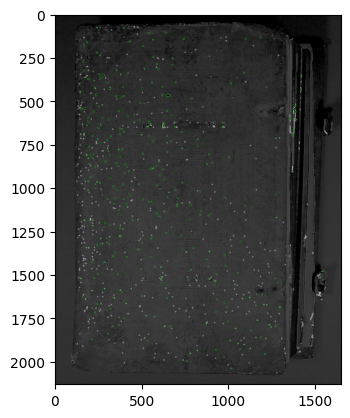

In [214]:
plt.imshow(blobs)

In [215]:
# cv2.imwrite('blobs_res.png', blobs)

True